<a href="https://colab.research.google.com/github/ShivinM-17/Tensorflow_practises/blob/main/Transfer_learning_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer learning
This is a process of leveraging a working model's existing architecture and learned parameters to be used for our own needs.   

There are two main benefits:
* Can leveerage an existing neural network architecture proven to work on problems similar to our own
* Can leverage a working neural network architecture which has already learned patterns similar to our own, then those can be used to adapt to our own model

In [ ]:
# Checking if gpu working
!nvidia-smi

Mon Jul 10 14:01:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Downloading the data
10% data of the Food 101 dataset

In [ ]:
# Getting data
import zipfile

# Downloading the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-07-10 14:01:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 172.253.117.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   180MB/s    in 0.9s    

2023-07-10 14:01:41 (180 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Checking the diretory which has the images
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/train'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_ric

### Creating data loaders
Using ImageDataGenerator class to load the images in batches

In [ ]:
# Setup data imputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Image: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "categorical"
                                                          )

print("Testing image: ")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode = "categorical")

Training Image: 
Found 750 images belonging to 10 classes.
Testing image: 
Found 2500 images belonging to 10 classes.


### Callbacks
These are extra functionality that can be added to the models to be performed during or after training. Some popular callbacks methods are:
* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [ ]:
# Create a TensorBoard callback (making it functionalised since we need to create one for each model we make)
import tensorflow as tf

# For making a timestamp
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


**Note:-** We can customize the directory where the TensorBoard logs gets saved however we want. Above method is just one example

## Tensorflow Hub
This is a repository of trained ML models which can be further fine-tuned and adjusted according to our needs

Earlier, we create our own neural network models from scratch.
Now, we'll be performing similar task, but majority of the model will come from tensorflow hub.


We'll be using  ResnetV2 50- feature vector
https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

And also, the EfficientNet B0 - feature vector                                    
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
# Well be comparing two model
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [ ]:
# Importing depedencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Creating a model creation function to make a function using URL
def create_model(model_url, num_classes=10):
  """
  This function takes a Tensorflow Hub URL and creates a keras sequential model with it

  Args:
     model_url (str): a tensorflow hub feature extraction URL
     num_classes (int): number of output in the output layers, (should be equal to number of output classes)

  Returns:
     An uncompiled keras sequential model with model_url as feature extractor
     layer and Dense output layer with num_classes output neurons.
  """
  # Download the pre-trained model
  feature_extraction_layer = hub.KerasLayer(model_url,
                                           trainable=False, # Making it false, since we don't require this model to be trained on some other dataset
                                           name = "feature_extraction_layer",
                                           input_shape = IMAGE_SHAPE+(3,)
                                           )
  # Now, creating the model
  model = tf.keras.Sequential([
      feature_extraction_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating and testing Resnet Tensorflow Hub feature extraction

In [ ]:
# Creating resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compiling the model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# Fitting the resnet model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(
                                      dir_name="tensorflow_hub",
                                      experiment_name="resnet_50v2_model"
                                  )]
                                  )

Saving TensorBoard log files to: tensorflow_hub/resnet_50v2_model/20230710-141821
Epoch 1/5
24/24 [==============================] - 32s 845ms/step - loss: 1.9384 - accuracy: 0.3453 - val_loss: 1.1778 - val_accuracy: 0.6372
Epoch 2/5
24/24 [==============================] - 19s 811ms/step - loss: 0.8864 - accuracy: 0.7493 - val_loss: 0.8533 - val_accuracy: 0.7304
Epoch 3/5
24/24 [==============================] - 17s 748ms/step - loss: 0.6090 - accuracy: 0.8400 - val_loss: 0.7580 - val_accuracy: 0.7676
Epoch 4/5
24/24 [==============================] - 18s 750ms/step - loss: 0.4839 - accuracy: 0.8760 - val_loss: 0.6951 - val_accuracy: 0.7776
Epoch 5/5
24/24 [==============================] - 17s 749ms/step - loss: 0.3721 - accuracy: 0.9120 - val_loss: 0.6739 - val_accuracy: 0.7764


Resnet works greatly with our data, which consists of only 10% of it. The processing time is also very less and the accuracy is also good.

In [ ]:
# Making a function to plot the loss curves
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  '''
  Returns seperate loss curves for training and validation metrics

  Args:
    history: Tensorflow history object

  Returns:
    Plots of training/validation loss and accuracy metrics
  '''
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("Epochs")
  plt.legend()

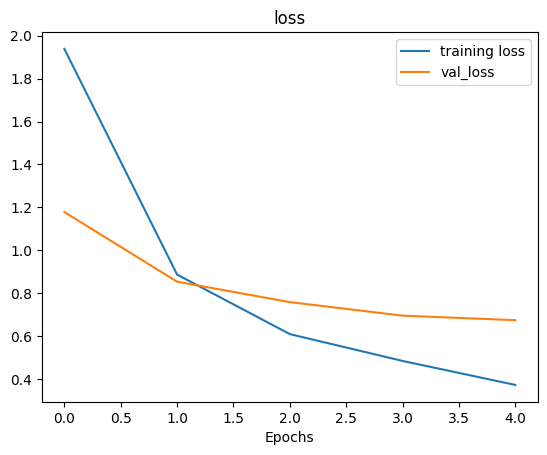

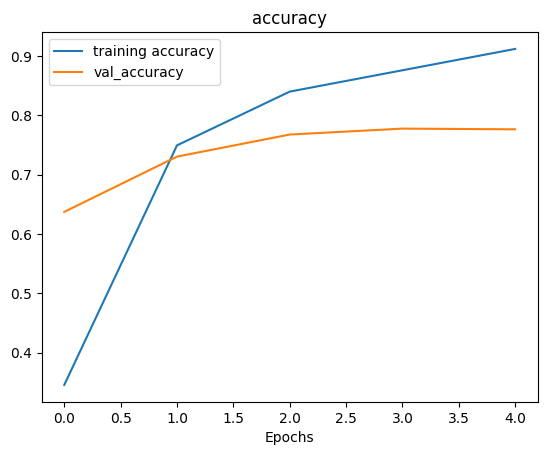

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 Tensorflow Hub feature extraction

In [ ]:
# Creating the efficient net model
efficientnet_model = create_model(
    model_url = efficientnet_url,
    num_classes = train_data_10_percent.num_classes
)

In [ ]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
# Compiling the model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

In [ ]:
# Fitting the model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(
                                                  dir_name = "tensorflow_hub",
                                                  experiment_name = "efficientnet_b0_model"
                                              )]
                                              )

Saving TensorBoard log files to: tensorflow_hub/efficientnet_b0_model/20230710-143616
Epoch 1/5
24/24 [==============================] - 37s 1s/step - loss: 1.9076 - accuracy: 0.3960 - val_loss: 1.3511 - val_accuracy: 0.7000
Epoch 2/5
24/24 [==============================] - 22s 935ms/step - loss: 1.0905 - accuracy: 0.7587 - val_loss: 0.8947 - val_accuracy: 0.8168
Epoch 3/5
24/24 [==============================] - 17s 717ms/step - loss: 0.7764 - accuracy: 0.8347 - val_loss: 0.7106 - val_accuracy: 0.8412
Epoch 4/5
24/24 [==============================] - 17s 720ms/step - loss: 0.6203 - accuracy: 0.8693 - val_loss: 0.6191 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 17s 749ms/step - loss: 0.5241 - accuracy: 0.8880 - val_loss: 0.5644 - val_accuracy: 0.8644


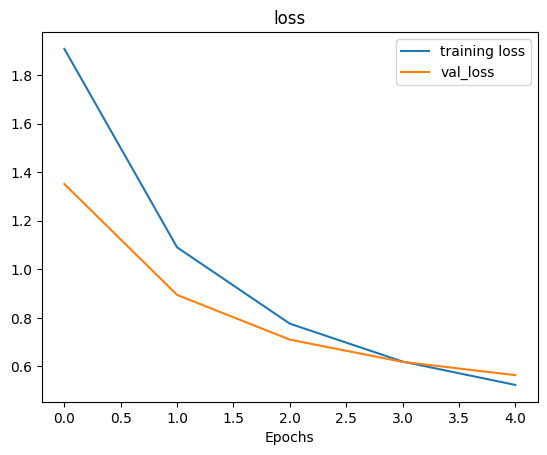

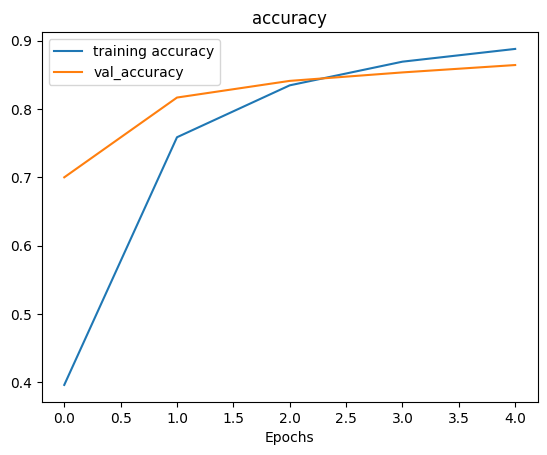

In [ ]:
# Plotting the loss curves of the model
plot_loss_curves(efficientnet_history)

### Different types of transfer learning
* **As is** transfer learning - using an existing model with no changes in it
* **Feature extraction** transfer learning - use the prelearned patterns of an existing model (eg. EfficientNetB0 trained on ImageNet, and then adjust the output layer for our own use)
* **Fine tuning** transfer learning - use the pretrained patterns of an existing model and "fine-tune" many or all of the underlying layers (including the output layers)

### Comparing the different models

In [31]:
# Upload Tensorflow dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 Vs ResNet50V2" \
  --description "Comparing two different pre-trained models for Food 101 dataset" \
  --one_shot

2023-07-10 14:58:51.497518: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/ajmTmNcDQAWogqGaQhd3aA/

[2023-07-10T14:58:53] Started scanning logdir.
[2023-07-10T14:58:55] Total uploaded: 60 scalars, 0 tensors, 2 binary objects (5.5 MB)
[2023-07-10T14:58:55] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/ajmTmNcDQAWogqGaQhd3aA/


TensoBoard link - https://tensorboard.dev/experiment/ajmTmNcDQAWogqGaQhd3aA/#scalars

In [32]:
# Checking out the TensorBoard experiment
!tensorboard dev list

2023-07-10 15:02:19.973270: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/ajmTmNcDQAWogqGaQhd3aA/
	Name                 EfficientNetB0 Vs ResNet50V2
	Description          Comparing two different pre-trained models for Food 101 dataset
	Id                   ajmTmNcDQAWogqGaQhd3aA
	Created              2023-07-10 14:58:53 (3 minutes ago)
	Updated              2023-07-10 14:58:55 (3 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5814839
Total: 1 experiment(s)


In [33]:
# To delete an experiment
# !tensorboard dev delete --experiment_id <Id>